In [1]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import numpy as np

In [2]:
interp = tf.lite.Interpreter("./models/hand_landmark.tflite")

In [3]:
interp.allocate_tensors()

In [4]:
class BlockSimple(nn.Module):
    def __init__(self, inp_channels=16):
        super(BlockSimple, self).__init__()
        full = inp_channels
        half = inp_channels // 2
        self.bn0 = nn.BatchNorm2d(full)
        self.prelu_inp = nn.PReLU(full)
        self.conv2d0 = nn.Conv2d(full, half, kernel_size=1, padding=0)
        self.bn1 = nn.BatchNorm2d(half)
        self.prelu_mid = nn.PReLU(half)
        self.depth_conv2d = nn.Conv2d(half, half, kernel_size=3, groups=half, padding=1)
        self.conv2d1 = nn.Conv2d(half, full, kernel_size=1, padding=0)
        
    def forward(self, inp):
        inp = self.bn0(inp)
        inp = self.prelu_inp(inp)
        skip = inp
        x = self.conv2d0(inp)
        x = self.bn1(x)
        x = self.prelu_mid(x)
        x = self.depth_conv2d(x)
        x = self.conv2d1(x)

        return skip + x

class BlockPool(nn.Module):
    def __init__(self, inp_channels, mid_channels=None, out_channels=None):
        super(BlockPool, self).__init__()
        inp = inp_channels
        mid = mid_channels if mid_channels else inp
        out = out_channels if out_channels else mid*2
        
        self.pad = out - inp
        
        self.bn0 = nn.BatchNorm2d(inp)
        self.prelu_inp = nn.PReLU(inp)
        self.b1 = nn.Sequential(
            nn.Conv2d(inp,mid,kernel_size=2, padding=0, stride=2),
            nn.BatchNorm2d(mid),
            nn.PReLU(mid),
            nn.Conv2d(mid,mid, kernel_size=3, groups=mid, padding=1),
            nn.Conv2d(mid,out, kernel_size=1, padding=0),
        )
        
        self.b2 = nn.MaxPool2d(2, stride=2)
        
    def forward(self, inp):
        inp = self.bn0(inp)
        inp = self.prelu_inp(inp)
        x1 = self.b1(inp)
        x2 = self.b2(inp)
        x2 = F.pad(x2, (0,0,0,0,self.pad,0)) # could be differences here
        return x1 + x2    

class RegBlock(nn.Module):
    def __init__(self, ):
        super(RegBlock, self).__init__()
        
        # self.bn0 = nn.BatchNorm2d(256)
        self.prelu = nn.PReLU(256)
        self.handflag = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=2),
            nn.Sigmoid()
        )
        self.landmarks = nn.Conv2d(256, 42, kernel_size=2)
        
    def forward(self, inp):
        # inp = self.bn0(inp)
        x = self.prelu(inp)
        flag = self.handflag(x).reshape(-1,1)
        landmarks = self.landmarks(x).reshape(-1,21,2)
        return flag, landmarks

conv0 = nn.Conv2d(3, 16, 3, stride=2, padding=1)

layers = \
    [conv0]                    +\
    [BlockSimple(16)] * 8      +\
    [BlockPool(16)]            +\
    [BlockSimple(32)] * 8      +\
    [BlockPool(32)]            +\
    [BlockSimple(64)] * 8      +\
    [BlockPool(64, 128, 256)]  +\
    [BlockSimple(256)] * 8     +\
    [BlockPool(256, 128, 256)] +\
    [BlockSimple(256)] * 8     +\
    [BlockPool(256, 128, 256)] +\
    [BlockSimple(256)] * 8     +\
    [BlockPool(256, 128, 256)] +\
    [BlockSimple(256)] * 8     +\
    [RegBlock()]

NN = nn.Sequential(*layers)

In [6]:
sd = torch.load('./best_weights_2.pth')
sd = {k.replace('module.', ''): v for k,v in sd.items()}

In [7]:
NN.load_state_dict(sd)

<All keys matched successfully>

In [ ]:
td = interp.get_tensor_details()

k,b = [interp.get_tensor(
        x['index']
       ) for x in td if re.match(f'^conv2d/',x['name'])]

In [10]:
inp = torch.zeros((1,3,256,256))

In [11]:
res = NN(inp)

In [12]:
sd = NN.state_dict()

In [13]:
tf_layers = [(x['name'], x['index']) for x in td]

In [14]:
from itertools import groupby

In [15]:
spl = [list(y) for x,y in groupby(tf_layers, lambda z: 'add' in z[0])]

In [16]:
spl2 = [w+a for w,a in zip(spl[:-1:2], spl[1::2])] + [spl[-1]]
spl2 = [[x for x in y if ('/' in x[0] or 'max' in x[0]) and 'padding' not in x[0]] for y in spl2]
# handling first conv layer
spl2.insert(0, spl2[0][:2])
spl2[1] = spl2[1][2:]

In [17]:
def fix_max_pooling(x):
    if len(x) > 6 and 'max' in x[6][0]:
        popped = x.pop(6)
        assert 'max' in popped[0], (popped, x)
        x.append('empty')
    return x

In [18]:
spl2 = [fix_max_pooling(x) for x in spl2]

In [19]:
names_pool = ['prelu_inp.weight']+\
             ['b1.'+x for x in ['0.weight', '0.bias',
                               '1.weight',
                               '2.weight', '2.bias',
                               '3.weight', '3.bias']]
names_reg = ['prelu_inp.weight']+\
            ['conv2d0.weight', 'conv2d0.bias',
             'prelu_mid.weight',
             'depth_conv2d.weight', 'depth_conv2d.bias',
             'conv2d1.weight', 'conv2d1.bias']
names_init =['0.weight',
             '0.bias']
names_fin = ['63.prelu.weight',
             '63.handflag.0.weight',
             '63.handflag.0.bias',
             '63.landmarks.weight',
             '63.landmarks.bias']

In [20]:
def map_block_pool(block, n):
    ln = len(block)
    if ln == 8:
        # regular block
        return [
            (f'{n}.' + y, x[1])\
            for x,y in zip(block, names_reg)
        ]
    if ln == 9:
        # pool block
        return [
            (f'{n}.' + y,x[1])\
            for x,y in zip(block, names_pool)
        ]
        
    if ln == 2:
        # first block
        return [
            (y, x[1])\
            for x,y in zip(block, names_init)
        ]
    if ln == 5:
        # last block
        return [
            (y, x[1])\
            for x,y in zip(block, names_fin)
        ]
    else:
        "something's wrong" 

In [21]:
mapped = [map_block_pool(x,i) for i,x in enumerate(spl2)]

In [22]:
mapped = [x for y in mapped for x in y]

In [23]:
tf_sd = {
    x[0]: interp.get_tensor(x[1]) for x in mapped
}

In [24]:
def to_ptensor(k, x):
    if len(x.shape) == 4: # conv kernel
        if x.shape[0] == 1 and 'handflag' not in k:     # depthwise conv
            return torch.from_numpy(x.transpose((3,0,1,2))).float()
        else:
            return torch.from_numpy(x.transpose((0,3,1,2))).float()
    if len(x.shape) == 3: # p_relu
        return torch.from_numpy(x.flatten()).float()
    if (len(x.shape)) == 1:
        return torch.from_numpy(x).float()
    else:
        print(x)

In [25]:
tf_sd_conv = {
    k: to_ptensor(k,v) for k,v in tf_sd.items()
}

In [26]:
NN.load_state_dict(tf_sd_conv, strict=False)

<All keys matched successfully>

In [28]:
torch.save(tf_sd_conv, './conv_weights.pt')

In [28]:
with torch.no_grad():
    res = NN(inp.cpu())

In [30]:
inp_tf = inp.cpu().numpy().transpose((0,2,3,1))

In [31]:
interp.set_tensor(0, tf.convert_to_tensor(inp_tf, 'float32'))
interp.invoke()

In [33]:
interp.get_tensor(893)

array([[121.7046  , 209.01286 , 121.43019 , 184.10387 , 118.020996,
        156.21976 , 119.69991 , 131.58287 , 124.44401 , 114.65887 ,
        122.28634 , 120.31778 , 123.25591 ,  80.80543 , 121.63984 ,
         64.51937 , 122.55424 ,  55.75334 , 127.28379 , 123.64844 ,
        127.76096 ,  76.56108 , 125.367966,  60.27936 , 125.10532 ,
         52.6923  , 131.19823 , 128.89928 , 131.65752 ,  91.282585,
        128.50342 ,  80.87325 , 127.32874 ,  74.3124  , 132.90588 ,
        135.15578 , 134.23297 , 107.45395 , 131.94511 ,  99.44381 ,
        130.31233 ,  94.57967 ]], dtype=float32)

In [31]:
td[3]

{'name': 'conv2d',
 'index': 3,
 'shape': array([  1, 128, 128,  16], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0)}

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from imageio import imread
import cv2



img = imread('/home/wolterlw/data/000001_color.png')[:, 80:-80]
img = cv2.resize(img, (256, 256))

normalized = np.ascontiguousarray(
    (2*((img / 255) - 0.5)).reshape(1,256,256,3)
)

tf_inp = tf.convert_to_tensor(normalized, 'float32')

In [13]:
img_pt = torch.from_numpy(normalized.transpose(0,3,1,2).astype('float32'))

In [25]:
coords = NN(img_pt)[1].detach().numpy()[0]

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

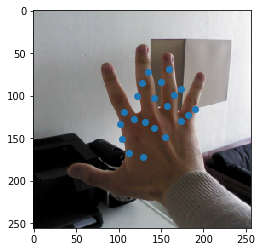

In [27]:
plt.imshow(img)
plt.scatter(
    coords[:,0], coords[:,1]
)

In [42]:
interp.set_tensor(0, tf_inp)
interp.invoke()

In [43]:
conv_res = interp.get_tensor(3)

In [44]:
res = interp.get_tensor(893)

In [45]:
coords = res.reshape(21,2)

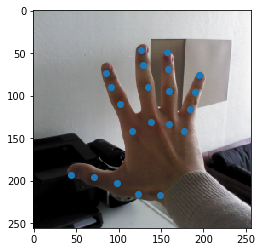

In [46]:
plt.imshow(img)
plt.scatter(coords[:,0], coords[:,1])

In [47]:
norm_pt = torch.from_numpy(normalized.transpose(0,3,1,2)).float()

In [48]:
with torch.no_grad():
    res_pt = NN(norm_pt)

In [52]:
res_pt[1]

tensor([[ 694.7824, 1551.4009,  906.7235, 1621.9370, 1028.9285, 1285.4072,
         1003.7543,  954.2339,  894.4274,  636.0726,  998.1830,  937.9546,
         1262.5734,  561.7294, 1355.4990,  539.3528, 1233.0173,  449.8889,
          838.4863,  855.9379, 1110.6997,  527.0376, 1228.9183,  595.7273,
         1239.4728,  596.4332,  757.2245,  807.5988,  981.4901,  582.2208,
          995.5520,  759.4512, 1049.9658,  778.9680,  670.0244,  696.5013,
          740.2614,  626.3035,  861.8826,  892.7646,  951.5217, 1026.4988]])

In [53]:
import tensorflow as tf

In [114]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, PReLU, DepthwiseConv2D, Input, Conv2D, add, concatenate, MaxPool2D, SeparableConv2D

In [127]:
class BlockSimpleK(tf.Module):
    def __init__(self, inp_channels=16):
        super(BlockSimpleK, self).__init__()
        full = inp_channels
        half = inp_channels // 2
        self.prelu_inp = PReLU(shared_axes=[1,2])
        self.conv2d0 = Conv2D(half, kernel_size=1, padding='valid')
        self.prelu_mid = PReLU(shared_axes=[1,2])
        self.depth_conv2d = DepthwiseConv2D(kernel_size=3, padding='same')
#         self.depth_conv2d = SeparableConv2D(half, kernel_size=3, padding='same')
        self.conv2d1 = Conv2D(full, kernel_size=1, padding='valid')
    
    @tf.Module.with_name_scope
    def __call__(self, x):
        inp = self.prelu_inp(x)
        skip = inp
        x = self.conv2d0(inp)
        x = self.prelu_mid(x)
        x = self.depth_conv2d(x)
        x = self.conv2d1(x)
        
        x = add([x, skip])
        
        return x
    
class BlockPoolK(tf.Module):
    def __init__(self, inp_channels, mid_channels=None, out_channels=None):
        super(BlockPoolK, self).__init__()
        inp = inp_channels
        mid = mid_channels if mid_channels else inp
        out = out_channels if out_channels else mid*2
        
        pad = out - inp
        self.pad = tf.constant([[0,0],[0,0], [0,0],[0,pad]])
        
        self.prelu_inp = PReLU(shared_axes=[1,2])
        self.conv2d0 = Conv2D(mid,kernel_size=2, padding='valid', strides=(2,2))
        self.prelu_mid = PReLU(shared_axes=[1,2])
        self.depth_conv2d = DepthwiseConv2D(kernel_size=3, padding='same')
#         self.depth_conv2d = SeparableConv2D(mid, kernel_size=3, padding='same')
        self.conv2d1 = Conv2D(out, kernel_size=1, padding='valid')
        
        
        self.max = MaxPool2D((2,2), strides=(2,2))
    
    @tf.Module.with_name_scope    
    def __call__(self, inp):
        inp = self.prelu_inp(inp)
        
        x1 = self.conv2d0(inp)
        x1 = self.prelu_mid(x1)
        x1 = self.depth_conv2d(x1)
        x1 = self.conv2d1(x1)
        
        x2 = self.max(inp)
        x2 = tf.pad(x2, self.pad)
        return add([x1, x2])
    
class RegBlockK(tf.Module):
    def __init__(self, ):
        super(RegBlockK, self).__init__()
        self.prelu = PReLU(shared_axes=[1,2])
        
        self.handflag0 = Conv2D(1, kernel_size=2)
        self.handflag1 = Activation('sigmoid')
        self.landmarks = Conv2D(42, kernel_size=2)
    
    @tf.Module.with_name_scope
    def __call__(self, inp):
        x = self.prelu(inp)
        flag = self.handflag0(x)
        flag = self.handflag1(flag)
        flag = tf.reshape(flag, (1,1))
        landmarks = self.landmarks(x)
        landmarks = tf.reshape(landmarks, (-1,42))
        return flag, landmarks

In [128]:
class LandmarkModel(tf.keras.Model):
    def __init__(self, ):
        super(LandmarkModel, self).__init__()
        conv0 = Conv2D(16, 3, strides=(2,2), padding='same')
        self.blocks = \
            [conv0]                     +\
            [BlockSimpleK(16)] * 8      +\
            [BlockPoolK(16)]            +\
            [BlockSimpleK(32)] * 8      +\
            [BlockPoolK(32)]            +\
            [BlockSimpleK(64)] * 8      +\
            [BlockPoolK(64, 128, 256)]  +\
            [BlockSimpleK(256)] * 8     +\
            [BlockPoolK(256, 128, 256)] +\
            [BlockSimpleK(256)] * 8     +\
            [BlockPoolK(256, 128, 256)] +\
            [BlockSimpleK(256)] * 8     +\
            [BlockPoolK(256, 128, 256)] +\
            [BlockSimpleK(256)] * 8     +\
            [RegBlockK()]
    
    def __call__(self, x):
        for i,b in enumerate(self.blocks):
            x = b(x)
        return x

In [129]:
model = LandmarkModel()
model(inp);

In [177]:
def get_kernel(index):
    return interp.get_tensor(index).transpose((1,2,3,0))

In [201]:
def set_init(lite, block):
    kernel = interp.get_tensor(lite[0][1]).transpose((1,2,3,0))
    bias = interp.get_tensor(lite[1][1])
    block.set_weights([kernel, bias])

def set_simple(lite, block):
    block.prelu_inp.set_weights(
        [interp.get_tensor(lite[0][1])]
    )
    k = get_kernel(lite[1][1])
    b = interp.get_tensor(lite[2][1])
    block.conv2d0.set_weights([k, b])
    
    block.prelu_mid.set_weights(
        [interp.get_tensor(lite[3][1])]
    )
    k = get_kernel(lite[4][1])
    b = interp.get_tensor(lite[5][1])
    block.depth_conv2d.set_weights([k, b])
    k = get_kernel(lite[6][1])
    b = interp.get_tensor(lite[7][1])
    block.conv2d1.set_weights([k, b])

def set_pool(lite, block):
    block.prelu_inp.set_weights(
        [interp.get_tensor(lite[0][1])]
    )
    k = get_kernel(lite[1][1])
    b = interp.get_tensor(lite[2][1])
    block.conv2d0.set_weights([k, b])
    
    block.prelu_mid.set_weights(
        [interp.get_tensor(lite[3][1])]
    )
    k = get_kernel(lite[4][1])
    b = interp.get_tensor(lite[5][1])
    block.depth_conv2d.set_weights([k, b])
    
    k = get_kernel(lite[6][1])
    b = interp.get_tensor(lite[7][1])
    
    block.conv2d1.set_weights([k, b])
    
def set_reg(lite, block):
    block.prelu.set_weights(
        [interp.get_tensor(lite[0][1])[:,:,::-1]]
    )
    k = get_kernel(lite[1][1])
    b = interp.get_tensor(lite[2][1])
    
    block.handflag0.set_weights([k,b])
    k = get_kernel(lite[3][1])
    b = interp.get_tensor(lite[4][1])
    block.landmarks.set_weights([k, b])

In [202]:
for i, lite, block in zip(range(100), spl2, model.blocks):
    set_as = 'none'
    if len(lite) == 2:
        set_init(lite, block)
        set_as = 'init'
    if len(lite) == 8:
        set_simple(lite, block)
        set_as = 'simple'
    if len(lite) == 9:
        set_pool(lite, block)
        set_as = 'pool'
    if len(lite) == 5:
        set_reg(lite, block)
        set_as = 'reg'
    print(f"set {i} as {set_as}")

set 0 as init
set 1 as simple
set 2 as simple
set 3 as simple
set 4 as simple
set 5 as simple
set 6 as simple
set 7 as simple
set 8 as simple
set 9 as pool
set 10 as simple
set 11 as simple
set 12 as simple
set 13 as simple
set 14 as simple
set 15 as simple
set 16 as simple
set 17 as simple
set 18 as pool
set 19 as simple
set 20 as simple
set 21 as simple
set 22 as simple
set 23 as simple
set 24 as simple
set 25 as simple
set 26 as simple
set 27 as pool
set 28 as simple
set 29 as simple
set 30 as simple
set 31 as simple
set 32 as simple
set 33 as simple
set 34 as simple
set 35 as simple
set 36 as pool
set 37 as simple
set 38 as simple
set 39 as simple
set 40 as simple
set 41 as simple
set 42 as simple
set 43 as simple
set 44 as simple
set 45 as pool
set 46 as simple
set 47 as simple
set 48 as simple
set 49 as simple
set 50 as simple
set 51 as simple
set 52 as simple
set 53 as simple
set 54 as pool
set 55 as simple
set 56 as simple
set 57 as simple
set 58 as simple
set 59 as simple
set 

In [203]:
from imageio import imread
import cv2

img = imread('/home/wolterlw/data/000001_color.png')[:, 80:-80]
img = cv2.resize(img, (256, 256))

normalized = np.ascontiguousarray(
    (2*((img / 255) - 0.5)).reshape(1,256,256,3)
)

tf_inp = tf.convert_to_tensor(normalized, 'float32')

In [276]:
ctf = lambda x: tf.convert_to_tensor(x, 'float32')

In [253]:
a50 = interp.get_tensor(728)
a60 = interp.get_tensor(869)
a61 = interp.get_tensor(883)

In [246]:
interp.set_tensor(0, tf_inp)

In [247]:
interp.invoke()

In [271]:
[x for x in td if x['name'] == 'conv2d_124']

[{'name': 'conv2d_124',
  'index': 882,
  'shape': array([  1,   2,   2, 256], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [272]:
inp = interp.get_tensor(879)
out = interp.get_tensor(882)

In [275]:
block = model.blocks[-2]

In [278]:
res = block.conv2d1(ctf(inp))

In [291]:
inp[0,:,:,0]

array([[1.        , 1.725558  ],
       [0.758317  , 0.42901996]], dtype=float32)

In [286]:
out

array([[[[-0.40936616, -1.2005785 ,  0.09423119, ..., -1.3419763 ,
           1.1670524 ,  1.04266   ],
         [ 0.762588  , -1.2401637 , -0.6713725 , ...,  2.29867   ,
          -0.8800035 , -0.47580087]],

        [[-0.809612  , -1.716474  , -0.90378207, ...,  1.4169928 ,
           1.1423383 , -4.0100074 ],
         [-2.0110202 , -1.8065943 , -1.8856597 , ..., -0.23902166,
           0.14811254,  1.9922674 ]]]], dtype=float32)

In [292]:
tf.nn.batch_normalization(res, 

<tf.Tensor: id=36325, shape=(1, 2, 2, 256), dtype=float32, numpy=
array([[[[  70.98465  ,  -42.059315 , -657.69934  , ..., -336.48987  ,
          -601.64105  ,  408.51813  ],
         [  -8.181027 ,  -18.59979  ,   10.506521 , ...,   12.000992 ,
            -4.7046185,  -93.052666 ]],

        [[   4.694283 ,  -24.988976 ,  -16.045195 , ...,  -74.76473  ,
             1.3253074,   52.025288 ],
         [   1.0100378,    9.792745 ,  112.53184  , ...,  -56.131065 ,
           -12.229649 ,  -62.951035 ]]]], dtype=float32)>

In [265]:
t = 

In [266]:
res = interp.get_tensor(882) + interp.get_tensor(871)

In [295]:
%%timeit
interp.invoke()

63.6 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
